## Indeed Product Science Homework
*Chunzi Wang*

-------

**Problem Statement:**

Indeed routes leads to sales team based on the potential quality of each lead. Based on the data that shows leads that were assigned and never assigned to a sales rep, we need to estimate the incremental impact the sales representatives had on revenue. 

**Key Questions:**

Does assigning sales rep work at all? How much more did accounts spend because there was sales intervention?

**Insights:**
- Using sales rep actually increases conversion rate and positively impact lead volume thus bringing in more revenue.
- If successfully convert a new account, sales intervention could bring in around 28 million revenue on average.
- If the account already has a budget to spend, having a sales rep will help promote the spending into 2.9 times of the original plan.

**Recommendations:**

- A large proportion of unassigned new accounts bring in revenue, sales rep shoule be assigned more to new accounts to increase conversion and encourage more spending.
- Age has a positive influence on revenue. The longer an account stays with Indeed, the more revenue it will bring in in the future. Sales rep should also pay close attention to regular accounts to help address their needs and retain them.

**Notebook Structure:**

This notebook contains the analysis, as well as the code which produces the analysis.

- In section 0, I uploaded the dataset and packages, did some initial inspection of the data to work with. 

- In section 1, I cleaned the data by changing the four date columns into datetime object type and analyzed their distribution. I did missing value diagnosis for "first_revenue_date" and "revenue" and anomaly detection for "age" and "assign_days" columns and went through my treatment method and process. 

- In section 2, I used log function to transform "revenue", filtered a dataframe that contains no missing value, and created two new features using primarily "first_revenue_date" column. 

- In section 3, I did exploratory analysis to find the correlation among different variables and created various visualizations for easy and quick understanding of the dataset and the relationship of all variables. 

- In section 4, I tried random forest and knn for missing value imputation for the most important "revenue" column. I provided functions to automatically train+fit the model, output prediction results and feature plots. 

- In section 5-9, I answered the detailed questions on Problem Statement sheet and came up with another interesting question to explore if there's relationship in seasonality and number of deals in the end.

In each section, I have detailed explanations for each step, including assumptions and decisions I make, methods I used and findings from analysis. 

I also included notes on the limitations of the dataset provided and what can be done to improve the analysis for next iteration of this data product.

### 0. Load packages and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math
import datetime
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('/Users/wangchunzi/Desktop/indeed_product_science_homework/homework_data_set.csv',index_col=0)

In [3]:
data.head()

,advertiser_id,assigned,date_assignment_starts,date_assignment_ends,first_revenue_date,date_created,age,assign_days,revenue
0,485,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-07-14,3855,138,NaN
1,598,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-08-02,3836,138,NaN
2,673,1,2017-02-01 00:00:00.000000,2017-04-28 15:36:30.000000,NaN,2006-08-17,3821,86,NaN
3,813,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-09-12,3795,138,NaN
4,1132,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-02,3744,138,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77891 entries, 0 to 77890
Data columns (total 9 columns):
advertiser_id             77891 non-null int64
assigned                  77891 non-null int64
date_assignment_starts    77891 non-null object
date_assignment_ends      77891 non-null object
first_revenue_date        8433 non-null object
date_created              77891 non-null object
age                       77891 non-null int64
assign_days               77891 non-null int64
revenue                   3340 non-null float64
dtypes: float64(1), int64(4), object(4)
memory usage: 5.9+ MB


In [5]:
data.describe().round(2)

,advertiser_id,assigned,age,assign_days,revenue
count,77891.00,77891.00,77891.00,77891.00,3.340000e+03
mean,7924270.95,0.48,309.96,120.48,4.865177e+07
std,3918984.90,0.50,488.80,39.53,1.736891e+08
min,485.00,0.00,-27.00,-2.00,1.200000e+04
25%,4317428.50,0.00,0.00,136.00,6.398444e+06
50%,10787880.00,0.00,0.00,137.00,1.514775e+07
75%,10807471.50,1.00,523.00,138.00,3.704959e+07
max,11199632.00,1.00,3855.00,138.00,6.533791e+09


Findings about the dataset:
- There're lots of missing values in "first_revenue_date" and "revenue" columns and needs missing value imputation.
- There're about 50% of the rows have "age" equal to zero, I suspect it means the account just joined Indeed and I'll look into it in following anlaysis.
- There're some abnormal data including negative value for "assign_days" and "age" that needs further investigation.
- "Assigned" is a binary column with value 0 and 1. I'd assume 1 means the lead got assigned to a sales representative and 0 means unassigned.
- "Revenue" contains wide-spread value from thousands to billions. Some of the data points are clearly outliers and will be dealt with in following analysis.

### 1. Data Cleaning

#### 1.1 Transform date_assignment_starts, date_assignment_ends, first_revenue_date, date_created into datetime type

In [6]:
data['date_assignment_starts'] = pd.to_datetime(data['date_assignment_starts'])
data['date_assignment_ends'] = pd.to_datetime(data['date_assignment_ends'])
data['first_revenue_date'] = pd.to_datetime(data['first_revenue_date'])
data['date_created'] = pd.to_datetime(data['date_created'])

In [7]:
data[['date_assignment_starts','date_assignment_ends','first_revenue_date','date_created']].describe()

,date_assignment_starts,date_assignment_ends,first_revenue_date,date_created
count,77891,77891,8433,77891
unique,3,6502,1636,2101
top,2017-02-01 00:00:00,2017-06-19 12:12:37.888680,2017-02-02 00:00:00,2017-02-01 00:00:00
freq,47051,64527,993,18074
first,2017-02-01 00:00:00,2017-02-01 02:40:29,2007-03-05 00:00:00,2006-07-14 00:00:00
last,2017-02-03 00:00:00,2017-06-19 12:12:37.888680,2017-06-18 00:00:00,2017-02-28 00:00:00


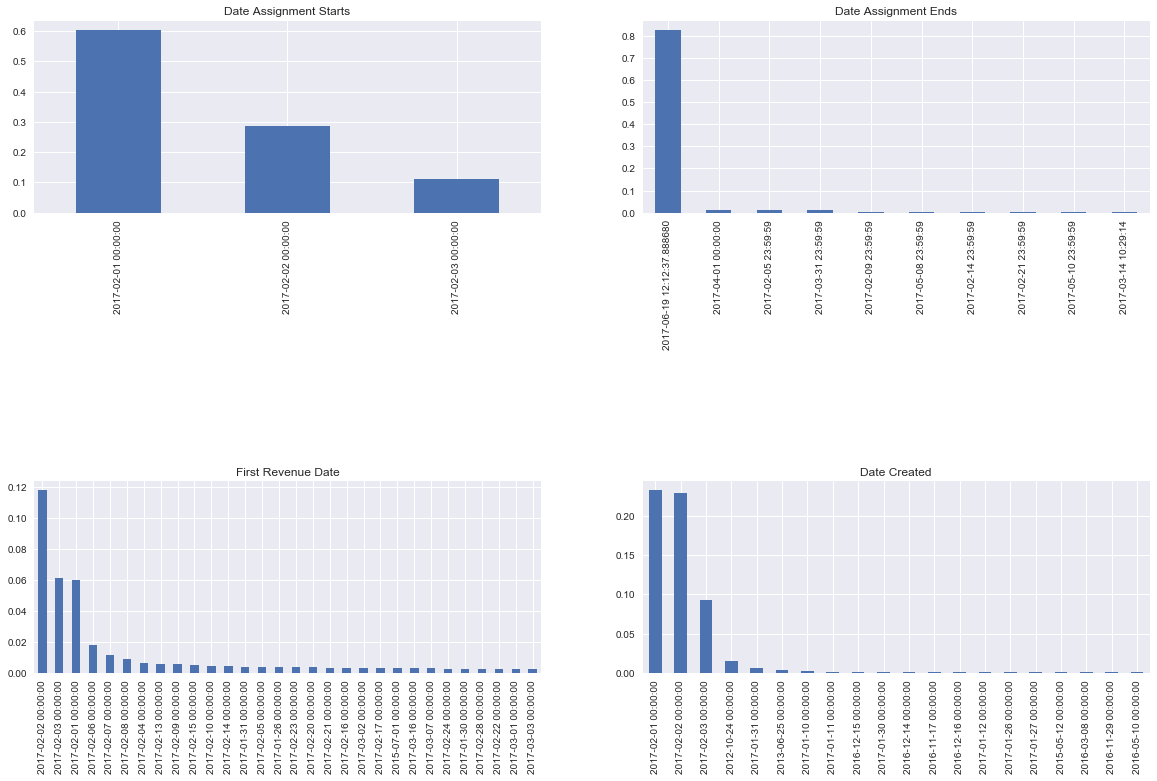

In [8]:
plt.subplot(3,2,1)
data['date_assignment_starts'].value_counts(normalize=True).plot.bar(figsize=(20,12),title='Date Assignment Starts')

plt.subplot(3,2,2)
data['date_assignment_ends'].value_counts(normalize=True)[:10].plot.bar(figsize=(20,12),title='Date Assignment Ends')

plt.subplot(3,2,5)
data['first_revenue_date'].value_counts(normalize=True)[:30].plot.bar(figsize=(20,12),title='First Revenue Date')

plt.subplot(3,2,6)
data['date_created'].value_counts(normalize=True)[:20].plot.bar(figsize=(20,12),title='Date Created')

plt.show()

Findings from the date columns:
- There're only three assignment starts date, from 2017-02-01 to 2017-02-03, with descending proportion.
- More than 80% of the assignment ends date is 2017-06-19.
- First revenue date is more sparsely distributed, but the top three dates are 2017-02-02, 2017-02-03, and 2017-02-01, which is exactly the date when sales intervention kicks in. Majority of the top 30 first_revenue_dates also happens after sales intervention.
- The top three dates that new accounts start coming to Indeed are 2017-02-1, 2017-02-02, 2017-02-03, exactly the time when sales rep started to reach out to potential leads. And these top dates count for more than 56% of rows.

#### 1.2 Missing Value Diagnosis for "first_revenue_date" and "revenue"

There're 69458 rows missing in total for "first_revenue_date" column.

This is what we know:
- For every row, the "first_revenue_date" must be later than date_created.
- There's a higher likelihood that the "first_revenue_date" is later than 2017-02-01 (from the plot above).
- For all the 8433 rows that have complete record of "first_revenue_date", 3340 of them has revenue amount, which is exactly the number of rows that have complete record of revenue. It means that rows that don't have "first_revenue_date" don't have a revenue either, and this can't be coincidence.

**Assumptions**:
- Rows whose "first_revenue_date" is not missing actually has revenue generated, we need to use statitiscal and machine learning methods to impute the missing value in "revenue" column.
- Rows that don't have "first_revenue_date" or "revenue" actually haven't generated any revenue yet, so the "first_revenue_date" doesn't exist for now and the "revenue" amount should be 0.

**Approaches**:
- For the existing 8433 rows, find the distribution of revenue and filling in the rest.
- Fill in missing value with 'N/A' (not applicable) at "first_revenue_date" and 1 at "revenue" (I'll explain why not use 0 in following paragraph). Since on second thought, it's not very practical for a media platform or service provider to have more than 77 thousand different advertisers and there's a conversion funnel of leads finally becoming accounts so it makes sense that 8433 leads (10.83% of the whole population) actually generated revenue, either voluntarily or under sales intervention.

In [9]:
# find that all non-missing revenue rows have first_revenue_date
sum(data[data['first_revenue_date'].notnull()]['revenue'].notnull())

3340

In [10]:
# fill in 0 at revenue for rows that don't have a first_revenue_date
data.loc[data[data['first_revenue_date'].isnull()].index,'revenue'] = 1
# fill in 'N/A' at first_revenue_date for rows that haven't generated the first revenue
data['first_revenue_date'].fillna('N/A',inplace=True)

#### 1.3 Anomaly Detection for "age" and "assign_days" column.

Findings from observing the data:

- **Age** is the days between "date_assignment_starts" and "date_created".
- **Assign_days** is the days between "date_assignment_ends" and "date_assignment_starts".

There're 42613 rows (54.72% of the whole population) that have age less or equal to zero, which means the leads started doing business with Indeed after sales intervention (if got assigned to a sales rep) and proves that assigning sales rep to leads actually works. So a negative number in age column won't be a problem since it has actual meaning.

There're 40812 rows that are not assigned with sales rep while their "assign_days" are not zero. I'll manually change the "assign_days" to zero for the rows that are unassigned.

In [11]:
# change assign_days to 0 for unassigned leads
data.loc[data[data['assigned']==0].index,'assign_days']=0

In [12]:
# put the rows that have age <= 0 into a sub dataframe and name it data_age0
data_age0 = data[data['age'] <= 0]
print data_age0.shape

(42613, 9)


Most of leads in this sub dataframe didn't get assigned a sales rep.

It's understandable that we could wait for a few days to see the new lead's williningness to buy advertising spots before reaching out.

In [13]:
data_age0['assigned'].value_counts(normalize=True)

0    0.918311
1    0.081689
Name: assigned, dtype: float64

Dates that most of these new clients created account is on 2017-02-02, 2017-02-01, and 2017-02-03.

In [14]:
data_age0['date_created'].value_counts(normalize=True)[:10]

2017-02-02    0.414521
2017-02-01    0.414498
2017-02-03    0.169502
2017-02-16    0.000141
2017-02-21    0.000117
2017-02-08    0.000117
2017-02-23    0.000117
2017-02-10    0.000117
2017-02-22    0.000094
2017-02-14    0.000070
Name: date_created, dtype: float64

It's clear that rows that have "assign_days" less than zero actually have the assignment starts and ends on the same day or there're some type that results to "date_assignment_ends" becoming earlier than "date_assignment_starts", I will fix the mistake and fill in "assign_days" with new value - zero.

In [15]:
# observe the rows that have assign_days < 0
data[data['assign_days'] < 0]

,advertiser_id,assigned,date_assignment_starts,date_assignment_ends,first_revenue_date,date_created,age,assign_days,revenue
34235,10765184,1,2017-02-02,2017-02-02 03:18:47,N/A,2017-01-31,2,-1,1.0
34270,10765921,1,2017-02-02,2017-02-02 03:20:53,N/A,2017-01-31,2,-1,1.0
34340,10768403,1,2017-02-02,2017-02-02 03:07:36,N/A,2017-01-31,2,-1,1.0
34517,10775233,1,2017-02-02,2017-02-02 03:05:51,N/A,2017-01-31,2,-1,1.0
34540,10775934,1,2017-02-02,2017-02-02 03:24:37,N/A,2017-01-31,2,-1,1.0
34650,10781520,1,2017-02-02,2017-02-02 03:26:43,N/A,2017-01-31,2,-1,1.0
34657,10781644,1,2017-02-02,2017-02-02 03:05:36,N/A,2017-01-31,2,-1,1.0
34659,10781682,1,2017-02-02,2017-02-02 18:16:53,N/A,2017-01-31,2,-1,1.0
34661,10781721,1,2017-02-02,2017-02-02 03:28:43,N/A,2017-01-31,2,-1,1.0
34666,10781793,1,2017-02-02,2017-02-02 02:06:38,N/A,2017-01-31,2,-1,1.0


In [16]:
# fill in "assign_days" with 0
data.loc[data[data['assign_days'] < 0].index,'assign_days']=0

### 2. Data Wrangling

#### 2.1 Use log function to transform revenue to better observe distribution pattern.

The original “revenue” column has wide-spread value with outliers. So I decided to take the logarithm of the revenue value of each row and transform then imto the exponent of 10 to see the distribution of revenue.

This is the reason why I filled in missing value with 1 instead of 0. A 0 at revenue will lead to math domain issue when calculating the log while 1 will give us a log of 0.

In [17]:
# create a new column named 'revenue_log10'
data['revenue_log10'] = data['revenue'].apply(lambda x: math.log10(x))

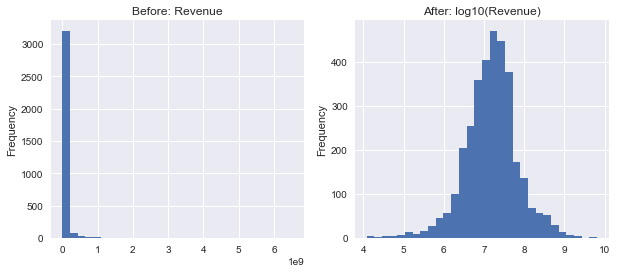

In [18]:
plt.subplot(1,2,1)
data[data['revenue']!=1].revenue.plot(figsize=(10,4),kind='hist',bins=30,title='Before: Revenue')

plt.subplot(1,2,2)
data[data['revenue_log10']!=0].revenue_log10.plot(figsize=(10,4),kind='hist',bins=30,title='After: log10(Revenue)')

plt.show()

It's clear that after transforming the revenue the distribution of revenue becomes observable and it's fair to say that it follows a normal distribution.

#### 2.2 Find the data that has revenue value and make it into a new dataframe for analysis and modeling.

In [19]:
data_clean = data[data['revenue']>1].reset_index(drop=True)
print data_clean.shape

(3340, 10)


#### 2.3 Create new features from date

Existing features doesn't include information in “first_revenue_date” column, that's the motivation for me to create two extra features:

- **revenue_days** is the days between “date_assignment_ends” and “first_revenue_date”. Since the revenue is a sum of all the revenue the account made in these years, it makes sense to know exactly how many days that the account has been an active contributor.
- **days_interval** is the interval between “first_revenue_date” and “date_created”. It measures the interval it takes for each lead to make the first purchase and become an account. 

I think both of them are useful information.

In [20]:
# since filling with N/A made the type of first_revenue_date column object, transform it into datetime again
data_clean['first_revenue_date'] = pd.to_datetime(data_clean['first_revenue_date'])

# create new features
data_clean['revenue_days'] = data_clean['date_assignment_ends'] - data_clean['first_revenue_date']
data_clean['days_interval'] = data_clean['first_revenue_date'] - data_clean['date_created']
# transform timedelta into numeric
data_clean['revenue_days'] = data_clean['revenue_days'].apply(lambda row: row.days)
data_clean['days_interval'] = data_clean['days_interval'].apply(lambda row: row.days)

### 3.Exploratory Analysis

#### 3.1 Correlation Analysis of all numeric variables

I made two heatmap, the first one using all the revenue data (inlcuding 0 revenue scenarios) and the second one using only the data that has actual revenue. It's clear that it's easier to observe the correlation between revenue and other variables when only rows with actual revenue are contained.

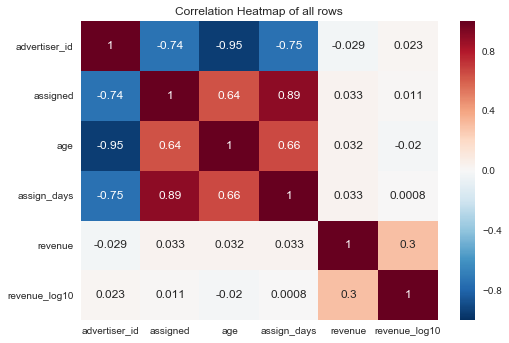

In [21]:
sns.heatmap(data.corr(),annot=True)
plt.title('Correlation Heatmap of all rows')
plt.show()

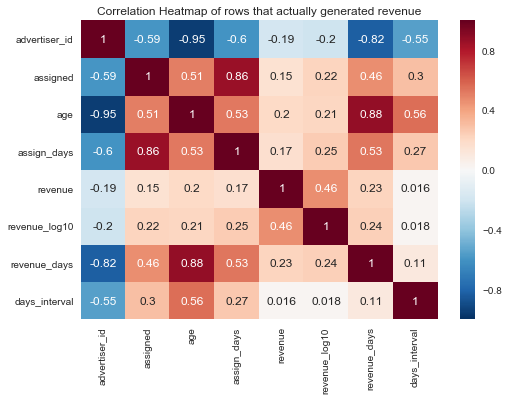

In [22]:
sns.heatmap(data_clean.corr(),annot=True)
plt.title('Correlation Heatmap of rows that actually generated revenue')
plt.show()

Findings from the correlation heatmap:
- "advertiser_id", "assigned", "age" and "assign_days" are a strong correlation group, with "advertiser_id" negatively correlated with the rest and the other three positively correlated with each other.
- "advertiser_id" is in sequence, the larger the id is, the 'younger' the account is and the less likely it's assigned to a sales rep.
- "age" and "assigned" has a positive correlation, which means Indeed is more likely to assign sales rep to accounts that have been with it for a while to increase further purchase in advertising spots.
- "assign_days" is also closely correlated to "assigned", which makes sense since you only have assign_days if you're assigned.
- "revenue_log10" has some correlation with the age of account, whether it's assigned to a sales rep and "assign_days". The older the account is and if it's assigned a sales rep, the larger revenue he will spend.
- "revenue_days" has a strong positive correlation with "age", which makes sense from the definition of these two features, and that makes "revenue_days" have similar correlation with other features the way age has.
- "days_interval" is an interesting one. It has negative correlation with "advertiser_id" and positive correlation with "age", which means new accounts spends less time considering whether to buy in than old accounts and that's a good opportunity for sales intervention to kick in and make things happen.

#### 3.2 Pair Plot on Numeric Variables to observe correlation and distribution

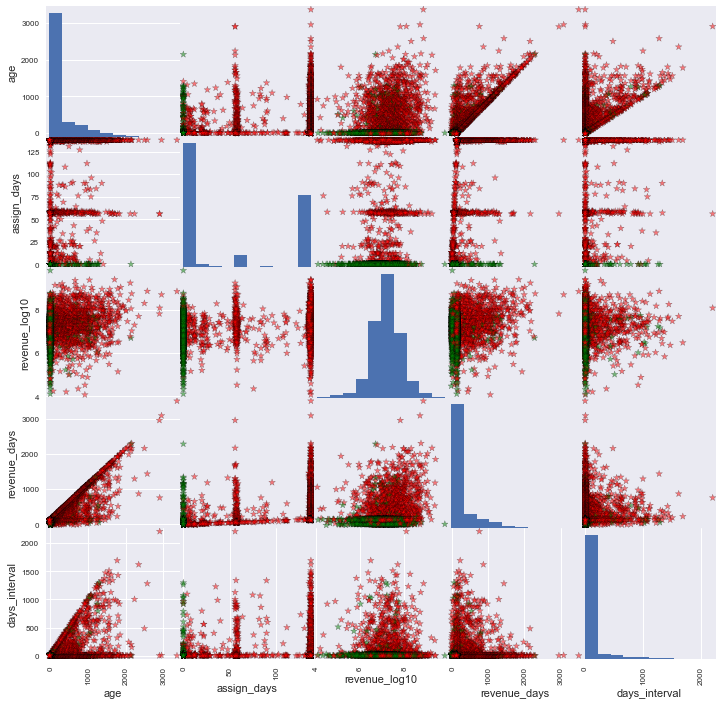

In [23]:
color_list = ['red' if i==1 else 'green' for i in data_clean.loc[:,'assigned']]
pd.scatter_matrix(data_clean.loc[:,['age','assign_days','revenue_log10','revenue_days','days_interval']],
                  c=color_list,
                  figsize=(12,12),
                  diagonal='hist',
                  alpha=0.5,
                  marker='*',
                  edgecolor='black')
plt.show()

Findings from the pair plot:
- "assign_days" and "age" are concentrated in a few buckets.
- It's clear to observe the correlation between "revenue_days" and "age", "age" and "days_interval".
- It's hard to predict the revenue base on whether the lead is assigned to a sales rep, or "assign_days". But "age", "revenue_days" and "days_interval" may have some insight to tell.

#### 3.3 Univariate Analysis on Revenue

Before doing missing value imputation on revnue, I'd like to observe the distribution of existing "revenue_log10" data points by making a histogram of itself, and seperate it into subgroups of assigned and unassigned. 

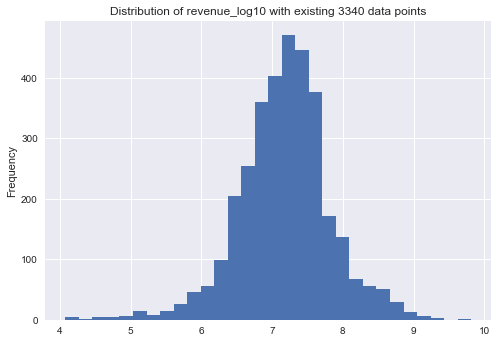

In [24]:
data_clean.revenue_log10.plot(kind='hist',bins=30)
plt.title('Distribution of revenue_log10 with existing 3340 data points')
plt.show()

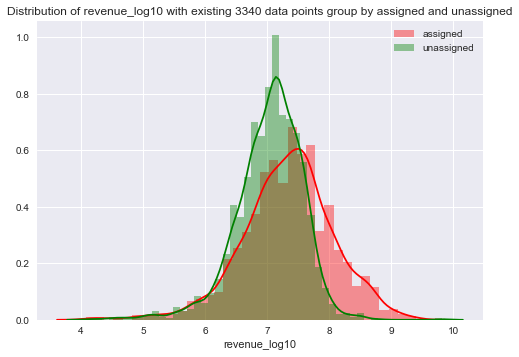

In [25]:
sns.distplot(data_clean[data_clean['assigned']==1].revenue_log10,color='red',label='assigned')
sns.distplot(data_clean[data_clean['assigned']==0].revenue_log10,color='green',label='unassigned')
plt.title('Distribution of revenue_log10 with existing 3340 data points group by assigned and unassigned')
plt.legend()
plt.show()

In [26]:
# observe descriptive statistics of revenue
print data_clean.revenue_log10.describe()
print data_clean[data_clean['assigned']==1].revenue_log10.describe()
print data_clean[data_clean['assigned']==0].revenue_log10.describe()

count    3340.000000
mean        7.176414
std         0.655635
min         4.079181
25%         6.806074
50%         7.180348
75%         7.568783
max         9.815165
Name: revenue_log10, dtype: float64
count    1565.000000
mean        7.333212
std         0.735905
min         4.079181
25%         6.906349
50%         7.365115
75%         7.767515
max         9.397940
Name: revenue_log10, dtype: float64
count    1775.000000
mean        7.038168
std         0.539270
min         4.113943
25%         6.752317
50%         7.091785
75%         7.392205
max         9.815165
Name: revenue_log10, dtype: float64


Findings:
- The existing data points of "revenue_log10" closely observe a normal distribution.
- After subgrouping revenue into assigned and unassigned, both still observe a normal distribution, with assigned being center more to the right and has a lower peak.
- It's fair to say that:
  - the whole 3340 rows of revenue_log10 observe a N(7.18,0.43) distribution.
  - the 1565 rows of assigned revenue_log10 observe a N(7.33,0.54) distribution.
  - the 1775 rows of unassigned revenue_log10 observe a N(7.04,0.29) distribution.

### 4. Missing Value Imputation for Revenue

After initial imputation of filling in 1 at "revenue" for leads that don't have a "first_revenue_date", there're still 5093 rows that have an actual "first_revenue_date" have missing value in "revenue". 

In order to accurately predict the revenue amount, features including 'prices of advertising slots of different time span', 'how many times the account made purchases' and so on should be provided. Due to the limited features available, it's not practical to predict accurate revenue amount for the 5093 rows. But on the other hand, from the previous heatmap, we could also see there's some correlation among revenue and the age of account, if it's assigned to sales rep and assign days. We could try to impute the missing value using the limited features we have using machine learning methods so we could have more data to work with in the following analysis.

Because there's not a linear correlation between revenue and predictors, and most of predictors have multicollinearity issues, Linear Regression is out of consideration.

The algorithms I chose are:
- **Random Forest**: It's a flexible model suitable for data that has a non-linear relationship and that doesn't get negatively influenced by multicollinearity. It's also more robust than a single decision tree. 
- **K Nearest Neighbors**: It finds the data points that are close to the test data and take the average value of the closest neighbors. The assumption is that accounts who have similar features tend to bring in similar revenue. 

**Approaches**:
- Find the subgroup of data that has revenue and make this into a new dataframe called data_clean.
- Split the data into training set and test set. Train the model with training set then test the predictive power of the model using test set.
- Use cross-validation to generalize the results.
- Choose the one model that has the lower Root Mean Squared Error.
- Retrain the model using the whole data_clean dataset, and use the model to predict the revenue for the rows with missing values.

Notes:
- I use "revenue_log10" instead of "revenue" as target variable since it's more observable than the real revenue. I'll transform it into the actual revenue number after imputation.

#### 4.1 Random Forest

In [27]:
def rf_cv_plot(data):
    
    import numpy as np
    
    # specify predictors and target variable
    x = data_clean[['assigned','age','assign_days','revenue_days','days_interval']]
    y = data_clean.revenue_log10
    
    # create an empty list and matrix to hold value in cross validation
    rmse_lst = []
    mat = np.zeros((5,5))

    # modeling process
    for i in range(5):
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
        rf = RandomForestRegressor(n_estimators=100)
        rf.fit(x_train,y_train)
        pred = rf.predict(x_test)
        rmse = math.sqrt(mean_squared_error(y_test,pred))
        rmse_lst.append(rmse)
        mat[i,:] = rf.feature_importances_

    print 'the RMSE of Random Forest after 5-fold cross validation is {}'.format(sum(rmse_lst)*1.0/len(rmse_lst))
    
    # calculate the average of importance for every feature
    importances = []
    for i in range(5):
        avg_imp = mat[:,i].mean()
        importances.append(avg_imp)

    # make feature importance plot
    importances = np.array(importances)
    indices = np.argsort(importances)[::-1]
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(x.shape[1]), importances[indices], color="orange", align="center")
    plt.xticks(range(x.shape[1]), [x.columns[i] for i in indices])
    plt.xlim([-1, x.shape[1]])
    return plt.show()

the RMSE of Random Forest after 5-fold cross validation is 0.662863436593


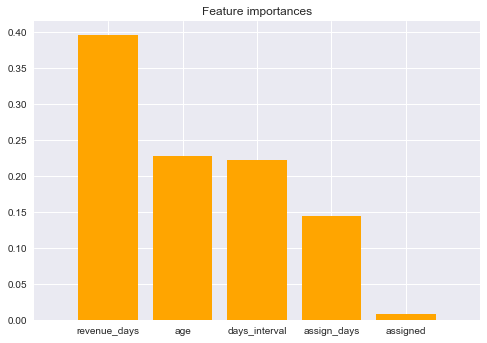

In [28]:
rf_cv_plot(data_clean)

"revenu_days" turns out to be the most important feature in random forest model, followed by "age", "days_interval", and "assign_days". 

#### 4.2 KNN

KNN is an algorithm based on calculating distance, so scaling is an indispensable process. 

I didn't choose Standard Scaler because the distribution of features are not normally distributed. I used Min-Max Scaler instead.

First step: find the optimal number of k.

In [29]:
def make_scree_plot(data):
    
    # specify predictors and target variable
    x = data[['assigned','age','assign_days','revenue_days','days_interval']]
    y = data.revenue_log10
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=2)
    
    # build a pipeline and empty list to store rmse value under different k
    rmse_lst = []
    for i in range(1,30):
        steps = [('scaler',MinMaxScaler()),
                 ('knn',KNeighborsRegressor(n_neighbors=i))]
        pipeline = Pipeline(steps)
        knn = pipeline.fit(x_train,y_train)
        pred = pipeline.predict(x_test)
        rmse = math.sqrt(mean_squared_error(y_test,pred))
        rmse_lst.append(rmse)
    
    # make the scree plot
    plt.plot(range(1,30), rmse_lst, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Root Mean Squared Error')
    return plt.show()

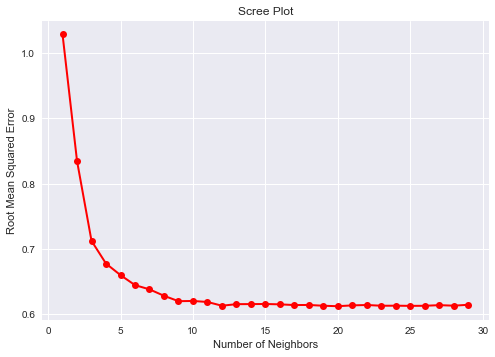

In [30]:
make_scree_plot(data_clean)

After observing the screeplot I decide to use 9 as the number for k.

Second step: Train model in a pipeline

In [31]:
def knn_cv(data):
    
    # specify predictors and target variable
    x = data_clean[['assigned','age','assign_days','revenue_days','days_interval']]
    y = data_clean.revenue_log10
    rmse_lst = []

    # training knn model in 5-fold cv
    for i in range(5):
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
        steps = [('scaler',MinMaxScaler()),
                 ('knn',KNeighborsRegressor(n_neighbors=9))]
        pipeline = Pipeline(steps)
        knn = pipeline.fit(x_train,y_train)
        pred = pipeline.predict(x_test)
        rmse = math.sqrt(mean_squared_error(y_test,pred))
        rmse_lst.append(rmse)
     
    print 'the RMSE of KNN after 5-fold cross validation is {}'.format(sum(rmse_lst)*1.0/len(rmse_lst))

In [36]:
knn_cv(data_clean)

the RMSE of KNN after 5-fold cross validation is 0.643130258806


The RMSE of KNN is lower than that of Random Forest, we'll use KNN to predict thr revenue for the other rows.

#### 4.3 Use KNN to impute missing value for Revenue

In [37]:
# Use data_clean to train the model
X_train = data_clean[['assigned','age','assign_days','revenue_days','days_interval']]
Y_train = data_clean.revenue_log10

# Find the dataframe that needs imputation
data_impute = data[data['revenue'].isnull()]

# Create revenue_days and days_interval features
data_impute['first_revenue_date'] = pd.to_datetime(data_impute['first_revenue_date'])
data_impute['revenue_days'] = data_impute['date_assignment_ends'] - data_impute['first_revenue_date']
data_impute['days_interval'] = data_impute['first_revenue_date'] - data_impute['date_created']
data_impute['revenue_days'] = data_impute['revenue_days'].apply(lambda row: row.days)
data_impute['days_interval'] = data_impute['days_interval'].apply(lambda row: row.days)

# Use the features of rest of the data as input
X_test = data_impute[['assigned','age','assign_days','revenue_days','days_interval']]
steps = [('scaler',MinMaxScaler()),
         ('knn',KNeighborsRegressor(n_neighbors=9))]
pipeline = Pipeline(steps)
knn = pipeline.fit(X_train,Y_train)
pred = pipeline.predict(X_test)

# Impute the pred as revenue_log10 for the missing rows
data.loc[data[data['revenue'].isnull()].index,'revenue_log10'] = pred
# Impute the actual revenue using 10**revenue_log10
data.loc[data[data['revenue'].isnull()].index,'revenue'] = 10**pred

After imputation, we can create a new dataframe called data_rev that contains 8433 rows that actually have revenue for the convenience of further analysis. But in all, we have two datasets to work with:
- **data**: The cleaned original dataset that contains 77891 rows and 10 clumns, inlcuding leads that have revenue and leads that never made a purchase.
- **data_rev**: The cleaned dataset that only contains 8433 rows of the leads who actually have real revenue. It has 12 columns since we add two features "revenue_days" and "days_interval". Data dataframe doesn't have these two because majority of the dataset there don't have "first_revenue_date", thus unable to calculate these two extra features.

In [38]:
# data that actually has revenue
data_rev = data[data['revenue']>1]

# add features
data_rev['first_revenue_date'] = pd.to_datetime(data_rev['first_revenue_date'])
data_rev['revenue_days'] = data_rev['date_assignment_ends'] - data_rev['first_revenue_date']
data_rev['days_interval'] = data_rev['first_revenue_date'] - data_rev['date_created']
data_rev['revenue_days'] = data_rev['revenue_days'].apply(lambda row: row.days)
data_rev['days_interval'] = data_rev['days_interval'].apply(lambda row: row.days)

print data_rev.shape

(8433, 12)


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77891 entries, 0 to 77890
Data columns (total 10 columns):
advertiser_id             77891 non-null int64
assigned                  77891 non-null int64
date_assignment_starts    77891 non-null datetime64[ns]
date_assignment_ends      77891 non-null datetime64[ns]
first_revenue_date        77891 non-null object
date_created              77891 non-null datetime64[ns]
age                       77891 non-null int64
assign_days               77891 non-null int64
revenue                   77891 non-null float64
revenue_log10             77891 non-null float64
dtypes: datetime64[ns](3), float64(2), int64(4), object(1)
memory usage: 6.5+ MB


In [40]:
data_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8433 entries, 10 to 77886
Data columns (total 12 columns):
advertiser_id             8433 non-null int64
assigned                  8433 non-null int64
date_assignment_starts    8433 non-null datetime64[ns]
date_assignment_ends      8433 non-null datetime64[ns]
first_revenue_date        8433 non-null datetime64[ns]
date_created              8433 non-null datetime64[ns]
age                       8433 non-null int64
assign_days               8433 non-null int64
revenue                   8433 non-null float64
revenue_log10             8433 non-null float64
revenue_days              8433 non-null int64
days_interval             8433 non-null int64
dtypes: datetime64[ns](4), float64(2), int64(6)
memory usage: 856.5 KB


### 5. Question 1 

#### 5.1 How many leads are represented in this dataset? 

Findings:
- There're 77891 leads represented in the dataset.
- 37079 (47.60%) are assigned with sales rep and 40812 (52.40%) are unassigned, almost half and half.
- In the whole population of 77891 leads, only 8433 (10.83%) have become actual accounts who brought in revenue. In this subgroup, 66% (2/3) are assigned with sales rep and 34% (1/3) are unassigned, which indicates leads assigned with sales rep are more likely to bring in revenue. 

In [41]:
print data.shape
print data_rev.shape

(77891, 10)
(8433, 12)


In [42]:
data['assigned'].value_counts()

0    40812
1    37079
Name: assigned, dtype: int64

In [43]:
data['assigned'].value_counts(normalize=True)

0    0.523963
1    0.476037
Name: assigned, dtype: float64

In [44]:
# from the leads that actually generated revenue, find out the proportion of assigned and unassigned
data_rev['assigned'].value_counts(normalize=True)

1    0.662042
0    0.337958
Name: assigned, dtype: float64

#### 5.2 Describe both the assigned and unassigned populations and their seperate average revenue. 

Findings about **revenue**:
- In the whole population, assigned leads generate average revenue of 6.7 million while unassigned leads only generate 1.4 million revenue on average. The number gets evened out by leads that don't have any revenue.
- If consider only the rows that have revenue, assigned leads generate average revenue of 46.14 million while unassigned leads only generate 18.02 million revenue on average.
- The proportion of leads that bring in revenue in assigned group is 15%, while in unassigned group the number is 7%. A higher proportion number in assigned group indicates that sales intervention could actually make a difference and almost double the conversion rate.

In [45]:
subgroup = data.groupby(by='assigned',axis=0,as_index=False)
subgroup.agg({'revenue':['mean','median','min','max','count','sum']})

assigned       revenue                                               
                    mean median  min           max  count           sum
0        0  1.258819e+06    1.0  1.0  6.533791e+09  40812  5.137494e+10
1        1  6.948229e+06    1.0  1.0  2.500000e+09  37079  2.576334e+11

In [46]:
subgroup2 = data_rev.groupby(by='assigned',axis=0,as_index=False)
subgroup2.agg({'revenue':['mean','median','min','max','count','sum']})

assigned       revenue                                             \
                    mean        median      min           max count   
0        0  1.802628e+07  1.015197e+07  13000.0  6.533791e+09  2850   
1        1  4.614604e+07  2.733759e+07  12000.0  2.500000e+09  5583   

                 
            sum  
0  5.137490e+10  
1  2.576334e+11

In [47]:
rev_proportion_assigned = 1-data[data['assigned']==1]['revenue_log10'].value_counts(normalize=True)[0]
rev_proportion_unassigned = 1-data[data['assigned']==0]['revenue_log10'].value_counts(normalize=True)[0]
print 'The proportion of leads that bring in revenue in assigned group is {}.'.format(rev_proportion_assigned.round(2))
print 'The proportion of leads that bring in revenue in unassigned group is {}.'.format(rev_proportion_unassigned.round(2))

The proportion of leads that bring in revenue in assigned group is 0.15.
The proportion of leads that bring in revenue in unassigned group is 0.07.


Next, I looked at the distribution of features under assigned and unassigned population:

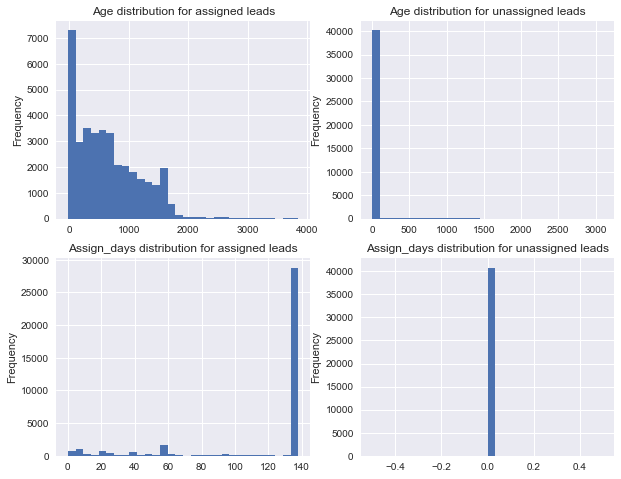

In [48]:
plt.subplot(2,2,1)
data[data['assigned']==1].age.plot(figsize=(10,8),kind='hist',bins=30,title='Age distribution for assigned leads')

plt.subplot(2,2,2)
data[data['assigned']==0].age.plot(figsize=(10,8),kind='hist',bins=30,title='Age distribution for unassigned leads')

plt.subplot(2,2,3)
data[data['assigned']==1].assign_days.plot(figsize=(10,8),kind='hist',bins=30,title='Assign_days distribution for assigned leads')

plt.subplot(2,2,4)
data[data['assigned']==0].assign_days.plot(figsize=(10,8),kind='hist',bins=30,title='Assign_days distribution for unassigned leads')

plt.show()

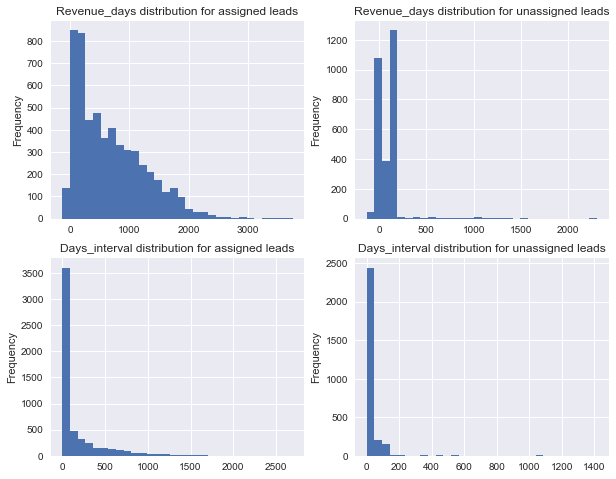

In [49]:
plt.subplot(2,2,1)
data_rev[data_rev['assigned']==1].revenue_days.plot(figsize=(10,8),kind='hist',bins=30,title='Revenue_days distribution for assigned leads')

plt.subplot(2,2,2)
data_rev[data_rev['assigned']==0].revenue_days.plot(figsize=(10,8),kind='hist',bins=30,title='Revenue_days distribution for unassigned leads')

plt.subplot(2,2,3)
data_rev[data_rev['assigned']==1].days_interval.plot(figsize=(10,8),kind='hist',bins=30,title='Days_interval distribution for assigned leads')

plt.subplot(2,2,4)
data_rev[data_rev['assigned']==0].days_interval.plot(figsize=(10,8),kind='hist',bins=30,title='Days_interval distribution for unassigned leads')

plt.show()

Findings about other features - **age**, **assign_days**, **revenue_days**, **days_interval** under assigned and unassigned population:
- Leads that are unassigned are pretty 'young' in age and it idicates that leads are more likely assigned to a sales rep if it's 'older' and has already had a relationship with Indeed.
- I changed the "assign_days" of unassigned group to 0 so that's what it shows here in the plot. In the assigned group, "assign_days" are mostly concentrated in 138 days with some others scattered around in smaller amount.
- Since unassigned leads are much younger, most of them don't have a long "revnue_days", while in assigned group, "revenue_days" has a long tail and looks like the right half of a normal distribution with decreasing frequency when days increase.
- "days_interval" tells the time between "first_revenue_date" and "date_created", in both groups, most of leads spend short time before making the first purchase, but in assigned group there're more leads having long interval time.

### 6. Question 2

#### 6.1 What're the most important metric to consider and why

**Hypothesis**: Making sales rep reaching out to leads could promote revenue, either help successfully convert a lead into account or encourage account spending more. And the resources spent in hiring and retaining sales rep is far less than revenue generated.

Metrics to consider:

- **Sales Rep Metrics**:
  - Rate of turning potential leads into accounts (conversion rate) through sales rep.
  - Average revenue achieved per sales rep in a fixed amount of time (e.g. a week, a month). 
  - Number of deals accomplished per week by sales rep.
  - Average revenue per account under sales intervention.

- **Comparison Metrics**:
  - Average revenue per account without sales intervention.
  - Original conversion rate (without sales rep).
  - Number of deals happen voluntarily per week.

- **Tradeoff Measures**:
  - Average time and money spent on every lead by sales rep. 

Reason in choosing these metrics:

Using sales representative to reach out to potential leads is a good way to help convert the lead to an actual account who purchases advertising spot and bringing in revenue. The key issue is to figure out two things:
1. If it actually increase conversion rate and positively impact lead volume thus bringing in more revenue.
2. If the amount of increasing revenue is worth the resources invested in sales rep.

So I came up with the metrics above, under those three categories, to try to answer the two questions using testing and experiment. After running the experiment in a few months, the data could be collected and to test the hypothesis, reach to conclusiong, and drives insights to action.

### 7. Question 3

#### Analyze any existing relationship between account age and revenue.

There're more than half of the leads (42613 rows) that have age less or equal to 0, meaning they just created their profile on Indeed's system on the same day or after the assignment starts. That gives me the idea of breaking down the analysis into two parts:
- Look at revenue situation of accounts that are new (age<=30) and are comparatively older (age>30).
- Explore the relationship of account age and revenue in the account pool that actually have revenue.

#### 7.1 Inspect revenue situation of new and regular accounts

Under my segmentation, there're 45115 new accounts and 32776 regular accounts in the population.

Findings:
- The total revenue from regular accounts are around 2352.04 billion, which is a lot more than the 73.8 billion total revenue from new accounts.
- The average revenue from regular accoutns are 7167 thousand, around 4.3 times the average revenue brought by new accounts. 
- By the revenue metric, regular accounts turn out to be more profitable than new accounts. But it's partly because the revenue column is a total of all revenues from multiple times while new accounts don't have enough chance to do that yet. 

In [50]:
# calculate the sum of revenue for all new and regular accounts
new_rev_sum = sum(data[data['age']<=30].revenue)
reg_rev_sum = sum(data[data['age']>30].revenue)

# calculate the average revenue for all new and regular accounts
new_rev_avg = new_rev_sum*1.0/len(data[data['age']<=30].revenue)
reg_rev_avg = reg_rev_sum*1.0/len(data[data['age']>30].revenue)

print 'The sum of revenue from new accounts are {} billion.'.format((new_rev_sum/1000000000).round(2))
print 'The sum of revenue from regular accounts are {} billion.'.format((reg_rev_sum/100000000).round(2))
print 'The average revenue from new accounts are {} thousand.'.format((new_rev_avg/1000).round(2))
print 'The average revenue from regular accounts are {} thousand.'.format((reg_rev_avg/1000).round(2))

The sum of revenue from new accounts are 73.8 billion.
The sum of revenue from regular accounts are 2352.04 billion.
The average revenue from new accounts are 1635.92 thousand.
The average revenue from regular accounts are 7176.1 thousand.


Next, I looked at the revenue distribution of new and regular accounts through histogram.

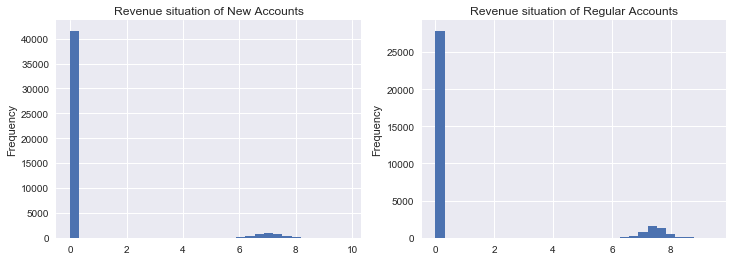

In [51]:
plt.subplot(1,2,1)
data[data['age']<=30].revenue_log10.plot(figsize=(12,4),kind='hist',bins=30)
plt.title('Revenue situation of New Accounts')

plt.subplot(1,2,2)
data[data['age']>30].revenue_log10.plot(figsize=(12,4),kind='hist',bins=30)
plt.title('Revenue situation of Regular Accounts')

plt.show()

Findings:
- No matter new accounts or regular accounts, majority of them won't bring in revenue. Only a small proportion of accounts will actually make a purchase.
- There're some small stacks on the right corner of both plots, I will "zoom in" to observe the details in the next couple of graphs.

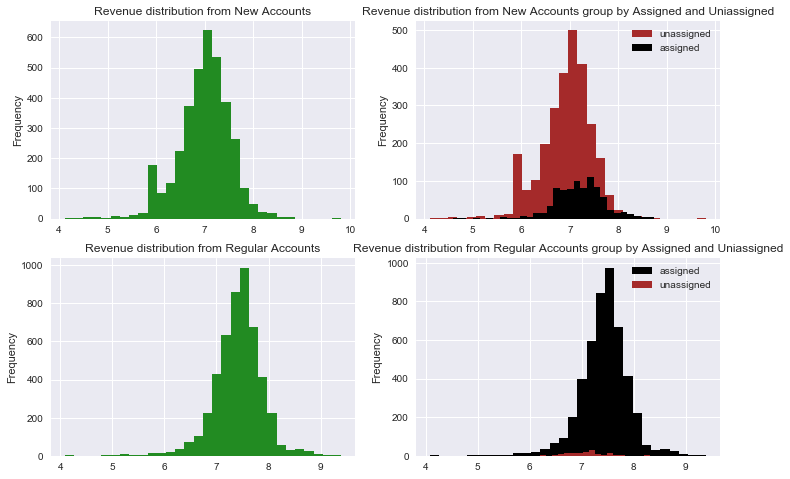

In [52]:
plt.subplot(2,2,1)
data[(data['age']<=30) & data['revenue_log10']>0].revenue_log10.plot(figsize=(12,8),kind='hist',bins=30,color='forestgreen')
plt.title('Revenue distribution from New Accounts')

plt.subplot(2,2,2)
data[(data['age']<=30) & (data['revenue_log10']>0) & (data['assigned']==0)].revenue_log10\
.plot(figsize=(12,8),kind='hist',bins=30,color='brown',label='unassigned')
data[(data['age']<=30) & (data['revenue_log10']>0) & (data['assigned']==1)].revenue_log10\
.plot(figsize=(12,8),kind='hist',bins=30,color='black',label='assigned')
plt.legend()
plt.title('Revenue distribution from New Accounts group by Assigned and Uniassigned')

plt.subplot(2,2,3)
data[(data['age']>30) & data['revenue_log10']>0].revenue_log10.plot(figsize=(12,8),kind='hist',bins=30,color='forestgreen')
plt.title('Revenue distribution from Regular Accounts')

plt.subplot(2,2,4)
data[(data['age']>30) & (data['revenue_log10']>0) & (data['assigned']==1)].revenue_log10\
.plot(figsize=(12,8),kind='hist',bins=30,color='black',label='assigned')
data[(data['age']>30) & (data['revenue_log10']>0) & (data['assigned']==0)].revenue_log10\
.plot(figsize=(12,8),kind='hist',bins=30,color='brown',label='unassigned')
plt.legend()
plt.title('Revenue distribution from Regular Accounts group by Assigned and Uniassigned')

plt.show()

**Findings and Conculsions**:
- In the two histogram of new accounts and regular accounts, it's clear that regular accounts have higher revenue on average since the plot looks like being moved to the right one centimeter.
- In the new acccount population, most of the revenue come from unassigned acounts, and there's only a small proportion that got assigned. 
- In the regular account population, most of the accounts are assigned and it's the assigned group that have more revenue. It could be that regular accounts already have a consistent purchase records so sales rep reach out to consolidate the relationship and promote new products, which enourage more buying. 

**New Hypothesis for testing**:

If we assign more sales rep to new accounts and reaching out to them at the very begining it could encourage them to spend more.

#### 7.2 Explore the relationship of account age and revenue

At this analysis, I will use the data_rev dataframe instead of data to better explore the relationship of account age and revnue given the condition that the account has brought in revenue.

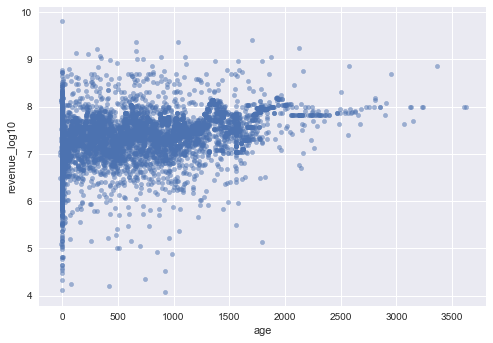

In [53]:
# use scatterplot to see the relationship of two variables
data_rev.plot(kind='scatter',x='age',y='revenue_log10',alpha=0.5)
plt.show()

Findings:
- It's observable that when the account age is large, revenue also tends to be higher.
- Smaller revenues, such as revenue below $500,000, have age less than 1000.
- There are a considerable number of new accounts who have little in age but generates a wide range of revenue.

In [54]:
# see the correlation in number
data_rev[['age','revenue_log10']].corr()

,age,revenue_log10
age,1.000000,0.408044
revenue_log10,0.408044,1.000000


Findings and next step:
- "age" and "revenue_log10" has a correlation of 0.41, which is moderately high. 
- I then tried to fit a **Linear Regression** model on the data to find the exact amount of influence increasing age might bring to revenue.

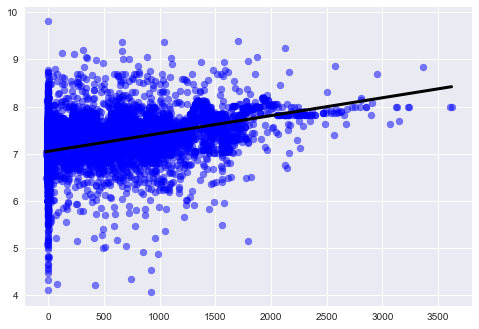

In [55]:
# fit a linear regression model of age being the single predictor and revenue_log10 being the target
reg = linear_model.LinearRegression()
x = data_rev['age'].reshape(-1,1)
y = data_rev['revenue_log10'].reshape(-1,1)
reg.fit(x,y)
prediction_space = np.linspace(min(x),max(x)).reshape(-1,1)

# plot the regression line
plt.scatter(x,y,color='blue',alpha=0.5)
plt.plot(prediction_space,reg.predict(prediction_space),color='black',linewidth=3)
plt.show()

In [56]:
# check the coefficient
reg.coef_

array([[ 0.00037822]])

Findings:
- This linear regression coefficient shows that when the account age increases 1000, then the target variable will increase 0.38. Since we use the log10 of actual revenue as the target variable here, actual revenue will increase 10^0.38, which is about 2.4 times the original amount. 

**Conclusion**:

Age does have a positive influence on revenue. The longer an account stays with Indeed, the more revenue it will bring in in the future. On average, everytime age increases 1000, the total revenue the account brings in could be 2.4 times of the start amount. 

### 8. Question 4

#### 8.1 What's the incremental value of assigning a lead to the sales team? 

Fisrtly, I did some exploratory analysis using histogram, boxplot, and descriptive statistics to understand the distribution of revenue in the whole population and within assigned and unassigned subgroup.

Findings:
- Both revenue in total, and revenue within assigned and unassigned subgroup closely observe a **normal distribution** in general. 
- Assigned group has a higher mean and a slightly lower standard deviation than unassigned group, which makes its distribution narrower.
- **revenue_assigned** ~N(7.40,0.48)
- **revenue_unassigned** ~N(6.93,0.52)


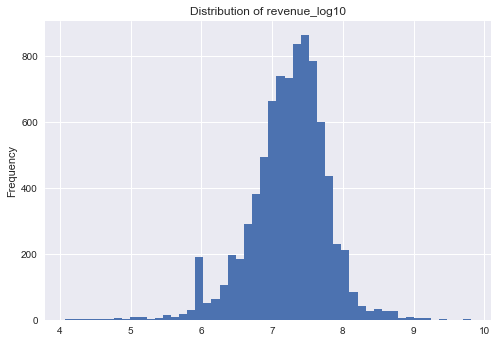

In [57]:
data_rev.revenue_log10.plot(kind='hist',bins=50)
plt.title('Distribution of revenue_log10')
plt.show()

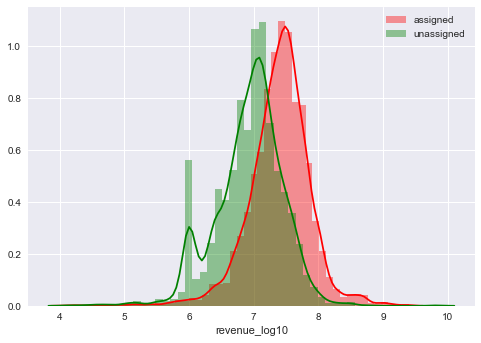

In [58]:
sns.distplot(data_rev[data_rev['assigned']==1].revenue_log10,color='red',label='assigned')
sns.distplot(data_rev[data_rev['assigned']==0].revenue_log10,color='green',label='unassigned')
plt.legend()
plt.show()

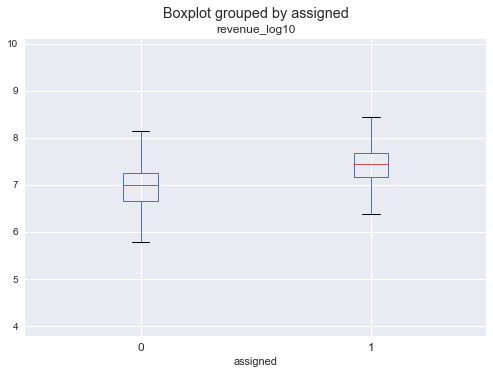

In [59]:
data_rev.boxplot(column='revenue_log10',by='assigned')
plt.show()

In [60]:
# seperate the revenue into two arrays
revenue_assigned = data_rev[data_rev['assigned']==1].revenue_log10
revenue_unassigned = data_rev[data_rev['assigned']==0].revenue_log10

In [61]:
revenue_assigned.describe()

count    5583.000000
mean        7.395857
std         0.480689
min         4.079181
25%         7.158809
50%         7.436760
75%         7.675619
max         9.397940
Name: revenue_log10, dtype: float64

In [62]:
revenue_unassigned.describe()

count    2850.000000
mean        6.930480
std         0.519292
min         4.113943
25%         6.661581
50%         7.006550
75%         7.256928
max         9.815165
Name: revenue_log10, dtype: float64

An intuitive way to calculate the incremental value of assigning a lead to sales team is to calculate the difference between the mean of two distributions:

increased_exponent = revenue_assigned.mean()-revenue_unassigned.mean()

Let's say log10(original_revenue) = a

After sales intervention, the new_exponent b = a+increased_exponent

Then new_revenue = 10^new_exponent = 10^(a+increased_exponent) = 10^a $*$ 10^increased_exponent = original_revenue $*$ 10^increased_exponent

In [63]:
# calculate the muptiplier
10**(revenue_assigned.mean()-revenue_unassigned.mean())

2.9199575104386857

I also came up with this idea to **find how many leads in the assigned group who actually have their first_revenue_date after 2017-02-1**, when the assignment starts. It means that these leads mostly likely bought advertising spots on Indeed for the first time, under sales influence.

In [64]:
# filter the conditions into a new dataframe called data_new
data_new = data_rev[(data_rev['assigned'] == 1) & (data_rev['first_revenue_date']>datetime.date(2017,02,01))]
print data_new.shape

(1067, 12)


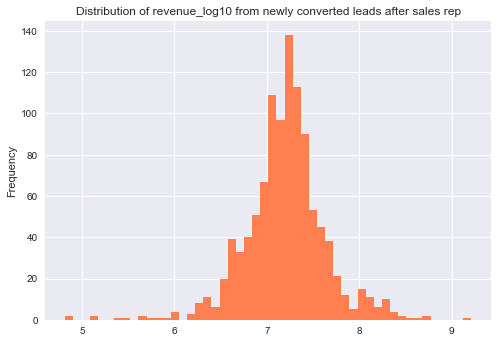

In [65]:
data_new.revenue_log10.plot(kind='hist',bins=50,color='coral')
plt.title('Distribution of revenue_log10 from newly converted leads after sales rep')
plt.show()

In [66]:
# calculate the average revenue brought in by these accounts
data_new.revenue.mean()

27991363.823232338

Given that there're 1067 rows of leads who actually converted to accounts after sales intervention, combining with the histogram showing differences above, we could confidently say that sales intervention could increase revenue and for every new account brought onboard, it'll generate around 28 million revenue on average. 

**Conclusion**:

Assigning sales rep could bring two major influences: making accounts spend more money and help convert a potential lead into account.

On **making account spending more money:** The incremental value is based on the original amount the account plans to buy without sales rep. On average, assigning sales rep to an account could encourage the account to buy 1.9 times more than his original plan, thus making the total revenue 2.9 times the amount without sales rep.

On **converting a lead into account:** For every new account brought onboard, it'll generate around 28 million revenue on average. 

**Limitations**:
- From Question 3, I feel that age is the main reason for assigning sales rep, so the higher revenue achieved by assigned group could be mainly due to longer years of accumulation in revenue, so it's hard to tell if it's getting assigned that got us high revenue. But it's also possible that new accounts in the unassigned group could buy more if they're assigned a sales rep, so my analysis still stands on solid ground.
- If We're not only given data of the total revenue, but also incremental revenue for everytime the accounts makes the purchase, especially the increased revenue after assignment_start_date, then it'd be more self-evident to see the direct effect of sales rep on revenue.

### 9. Bonus Questions

#### 9.1 Are there any seasonality in the time when accounts made purchase for the first time?

In [67]:
# extract the month from first_revenue_date columns
data_rev['revenue_month'] = data_rev['first_revenue_date'].apply(lambda row: row.month)

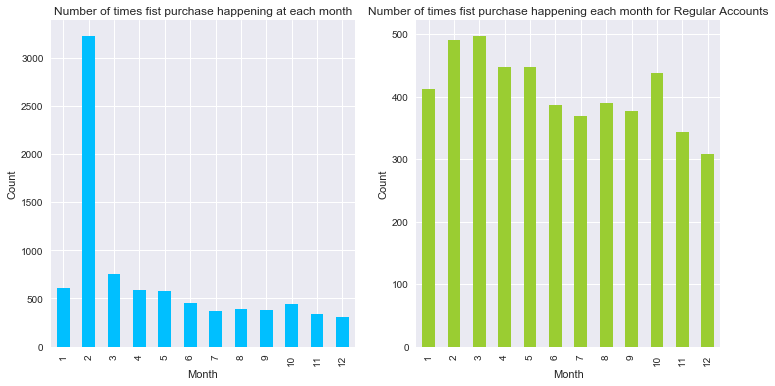

In [68]:
plt.subplot(1,2,1)
data_rev['revenue_month'].value_counts().sort_index().plot(figsize=(12,6),kind='bar',color='deepskyblue')
plt.ylabel('Count')
plt.xlabel('Month')
plt.title('Number of times fist purchase happening at each month')

plt.subplot(1,2,2)
data_rev[data_rev['age']>30].revenue_month.value_counts().sort_index().plot(figsize=(12,6),kind='bar',color='yellowgreen')
plt.ylabel('Count')
plt.xlabel('Month')
plt.title('Number of times fist purchase happening each month for Regular Accounts')

plt.show()

Findings:
- From the plot on the left, February is when most accounts make their first purchase. It's understandable since most new accounts have their first revenue date in February.
- In the plot on the right, I only included Regular Accounts to better observe the number of first purchase on different months and trends of seasons. There're more accounts starting their first purchase at the beginning of year, February, March, April and May. I guess it's because at the start of year, after holiday seasons, people start to look for new jobs and opportunities and that's the time when Indeed has most traffic, so accounts are also flocking in. Then the heat gradually fades, so we could see a decrease in the total number of accounts making first purchase in the following months, except for October, which is also a key month for job seekers. 

Conclusions:

There's not an obvious seasonality in the time when accounts made their first purchase, though the beggining months of every year have more accounts coming. A more useful way would be to assign sales rep to potential leads then the number will soar at that time. 